<h1>Mind your Building<h1>
<h2>Datamining - Prediction model </h2>
<h3>Wico Mulder, feb 2023.</h3>

In [46]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics 
import matplotlib.pyplot as plt

%matplotlib inline

folder="../data/student_data/"


In [47]:
sensor_overview=pd.read_excel(folder+"STUDENT sensor overview.xlsx")
sensor_overview.sample(10)

,sensorId,zone_name,floor,challenge_id
7,okku-room-6,0.40,0th,Mirte
9,okku-sound-10,0.44,0th,Eva
23,okku-sound-17,1.37,1st,Xavi
18,okku-sound-19,1.05 trappenhuis,1st,Julian
47,okku-sound-21,2.38,2nd,Stijn
16,okku-sound-16,1.03,1st,Jaap
27,okku-room-7,damestoilet eerste verdieping,1st,Merel
44,okku-door-8,2.35,2nd,Suus
1,okku-sound-3,0.00 Deur naar werklandschap bg,0th,Laura
19,okku-room-10,1.20,1st,Chris


In [48]:
def load(filename):
    df=pd.read_csv(filename ,sep=";")
    df['datetime']=pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M:%S.%f')
    df['date']=df['datetime'].dt.date
    print("{a:<60} {b:<20} {c}".format(a=filename,b=str(df.shape),c=str(df.columns.values)))
    return df

#sensor measurements
#basic_df=load(folder+"challenge_values_type_basic.csv")
co2_df=load(folder+"challenge_values_type_co2.csv")
#door_df=load(folder+"challenge_values_type_door.csv")
sound_df=load(folder+"challenge_values_type_sound.csv")

../data/student_data/challenge_values_type_co2.csv           (938044, 10)         ['index' 'datetime' 'co2' 'temperature' 'humidity' 'light' 'motion' 'vdd'
 'challenge_id' 'date']
../data/student_data/challenge_values_type_sound.csv         (2296653, 11)        ['index' 'datetime' 'temperature' 'humidity' 'light' 'soundAvg'
 'soundPeak' 'motion' 'vdd' 'challenge_id' 'date']


<h2>Question</h2>
<p>Given the stairs Sound-2 (Yvonne) and Sound-19 (Julian)| and maybe the rooms (sound 25,sound 4,sound,14) </p>
<p>And given the (maybe only movement??) activity on the second floor (door 4,5,14,12,7,8,11,13,15,6,1,9... co2 114,115,116,117,113 room 15, sound 21,sound 11, sound 12) <p>
<p>Can we predict 2nd floor activity from movements and/or sound 2 and 19? <p>


In [49]:
def filterSensors(df,myregex):
    df_filtered=df[df.challenge_id.str.match(myregex)]
    print(df_filtered.challenge_id.unique())
    if len(df_filtered)==0:
        print("No filter results.")
        succes=False
    else:
        succes=True
    return (succes,df_filtered)

def filterDate(df,startdatestr,stopdatestr):
    start_date=datetime.strptime(startdatestr, "%d-%m-%Y")
    stop_date=datetime.strptime(stopdatestr, "%d-%m-%Y")
    print("start date",start_date)
    print("stop date",stop_date)
    df_filtered=df[(df.datetime>=start_date) & (df.datetime<=stop_date)]
    if len(df_filtered)==0:
        print("No filter results.")
        succes=False
    else:
        succes=True
        return (succes,df_filtered)

def normalize01(df,column_name):
    max_value = df[column_name].max()
    min_value = df[column_name].min()
    print("Normalizing : ",column_name,"min =",min_value,"max=",max_value)
    result = df.copy()
    result[column_name] = (df[column_name] - min_value) / (max_value - min_value)
    return result

def resamplePerChallengeId(df_with_multiple_ids):
    i=0
    all_sensors_resampled_df=None
    
    for challenge_id in df_with_multiple_ids['challenge_id'].unique():
        one_sensor_df=df_with_multiple_ids[df_with_multiple_ids['challenge_id']==challenge_id].copy()
        one_sensor_df=one_sensor_df.set_index("datetime")
     
        print("resampling",challenge_id)
        one_sensor_df=one_sensor_df.resample('h').mean()
        #due to resampling the id columns was lost,put it back
        one_sensor_df['challenge_id']=challenge_id
        if i==0:
            all_sensors_resampled_df=one_sensor_df
        else:
            all_sensors_resampled_df=pd.concat([all_sensors_resampled_df,one_sensor_df],axis=0)
        i=i+1 
    return all_sensors_resampled_df


# select and prepare the data

In [50]:

startdatestr="01-10-2022"
stopdatestr="15-10-2022"

#----------------------
#    sound sensors 
#----------------------

df=sound_df.copy()
#address nans 
nandata=df[df.isnull().any(axis=1)]
df=df.fillna(0)
print("NaN data : ",nandata.shape)
(succes,subset)=filterDate(df,startdatestr=startdatestr,stopdatestr=stopdatestr)
challenge_id="Laura|Yvonne|Karel|Julian"
(succes,subset_sound)=filterSensors(subset,challenge_id)
subset_sound=subset_sound[['challenge_id','datetime','soundAvg','motion']]
subset_sound=resamplePerChallengeId(subset_sound)
# Normalize the data
subset_sound_01=normalize01(subset_sound,'soundAvg')
subset_sound_01=normalize01(subset_sound_01,'motion')

NaN data :  (88194, 11)
start date 2022-10-01 00:00:00
stop date 2022-10-15 00:00:00
['Karel' 'Julian' 'Yvonne' 'Laura']
resampling Karel
resampling Julian
resampling Yvonne
resampling Laura
Normalizing :  soundAvg min = 26.666666666666668 max= 53.833333333333336
Normalizing :  motion min = 0.0 max= 9.5


In [51]:
subset_sound_01.sample(5)

,soundAvg,motion,challenge_id
datetime,,,
2022-10-03 08:00:00,0.840491,0.719298,Julian
2022-10-06 18:00:00,0.601227,0.000000,Yvonne
2022-10-02 16:00:00,0.521472,0.000000,Julian
2022-10-01 23:00:00,0.269939,0.000000,Laura
2022-10-13 21:00:00,0.337423,0.000000,Karel


### define/prepare the X columns 

In [52]:
i=0
X_data=None
subset_sound_01=subset_sound_01.reset_index()
for challenge_id in subset_sound_01['challenge_id'].unique():
    one_sensor_df=subset_sound_01[subset_sound_01['challenge_id']==challenge_id].copy()
    one_sensor_df=one_sensor_df.set_index("datetime")
    one_sensor_df=one_sensor_df[['soundAvg','motion']]
    one_sensor_df.columns=one_sensor_df.columns+"_"+challenge_id
    
    if i==0:
        X_data=one_sensor_df
    else:
        X_data=pd.concat([X_data,one_sensor_df],axis=1)
    i=i+1 

In [53]:
X_data.sample(10)

,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura
datetime,,,,,,,,
2022-10-04 15:00:00,0.496933,0.000000,0.478528,0.000000,0.613497,0.000000,0.300613,0.017544
2022-10-10 08:00:00,0.834356,0.631579,0.754601,0.701754,0.895706,0.754386,0.619632,0.508772
2022-10-05 23:00:00,0.312883,0.000000,0.490798,0.000000,0.687117,0.000000,0.269939,0.000000
2022-10-12 00:00:00,0.319018,0.000000,0.411043,0.000000,0.638037,0.000000,0.269939,0.000000
2022-10-03 13:00:00,0.779141,0.245614,0.680982,0.017544,0.822086,0.175439,0.558282,0.175439
2022-10-09 14:00:00,0.306748,0.000000,0.392638,0.000000,0.582822,0.000000,0.269939,0.000000
2022-10-07 07:00:00,0.791411,0.421053,0.699387,0.578947,0.840491,0.508772,0.588957,0.561404
2022-10-02 21:00:00,0.294479,0.000000,0.478528,0.000000,0.631902,0.000000,0.269939,0.000000
2022-10-07 18:00:00,0.319018,0.000000,0.423313,0.000000,0.607362,0.000000,0.269939,0.000000


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


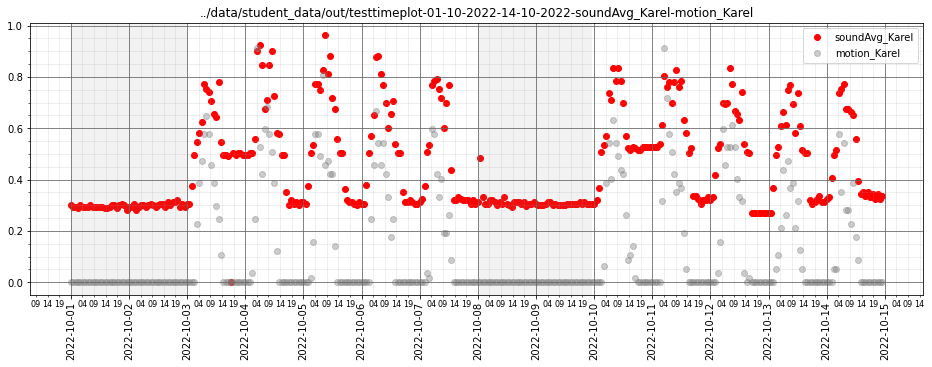

In [79]:
%load_ext autoreload
%autoreload 2

from TimePlotter import TimePlotter
timeplotter=TimePlotter()
df=X_data.copy().reset_index()
timeplotter.plot(folder+"out/test",df,'soundAvg_Karel',columnname2='motion_Karel')

### Get and prepare Y data ; resample, group as second floor, average over all sensors, define 'presence' (Y column)

In [54]:
#----------------------
#    co2 sensors 
#----------------------
df=co2_df.copy()
#address nans 
nandata=df[df.isnull().any(axis=1)]
df=df.fillna(0)
print("NaN data : ",nandata.shape)
(succes,subset)=filterDate(df,startdatestr=startdatestr,stopdatestr=stopdatestr)
challenge_id="Bjorn|Max|Esther|Rob|Nienke"
(succes,subset_co2)=filterSensors(subset,challenge_id)
subset_co2=subset_co2[['challenge_id','datetime','co2','motion']]
subset_co2=resamplePerChallengeId(subset_co2)
# Normalize the data
subset_co2_01=normalize01(subset_co2,'co2')
subset_co2_01=normalize01(subset_co2_01,'motion')


NaN data :  (495, 10)
start date 2022-10-01 00:00:00
stop date 2022-10-15 00:00:00
['Esther' 'Bjorn' 'Max' 'Rob' 'Nienke']
resampling Esther
resampling Bjorn
resampling Max
resampling Rob
resampling Nienke
Normalizing :  co2 min = 381.2 max= 1579.1666666666667
Normalizing :  motion min = 0.0 max= 16.333333333333332


In [55]:
subset_co2_01.sample(5)

,co2,motion,challenge_id
datetime,,,
2022-10-08 09:00:00,0.087621,0.000000,Rob
2022-10-04 23:00:00,0.011520,0.000000,Bjorn
2022-10-05 08:00:00,0.680431,0.489796,Nienke
2022-10-02 16:00:00,0.079412,0.000000,Esther
2022-10-09 15:00:00,0.196555,0.000000,Max


In [56]:

subset_co2_01.reset_index()
grouped=subset_co2_01.groupby(['datetime']).agg({'motion': ['mean','std'],'co2': ['mean','std']})
second_floor_df=pd.DataFrame(grouped).reset_index()
second_floor_df.columns = second_floor_df.columns.get_level_values(0)+"_"+second_floor_df.columns.get_level_values(1)
second_floor_df = second_floor_df.rename(columns={'datetime_': 'datetime'})


In [57]:
second_floor_df

,datetime,motion_mean,motion_std,co2_mean,co2_std
0,2022-10-01 00:00:00,0.0,0.0,0.147778,0.149972
1,2022-10-01 01:00:00,0.0,0.0,0.147695,0.151742
2,2022-10-01 02:00:00,0.0,0.0,0.144773,0.150426
3,2022-10-01 03:00:00,0.0,0.0,0.147389,0.149538
4,2022-10-01 04:00:00,0.0,0.0,0.147055,0.150837
...,...,...,...,...,...
331,2022-10-14 19:00:00,0.0,0.0,0.182782,0.158728
332,2022-10-14 20:00:00,0.0,0.0,0.180751,0.158624
333,2022-10-14 21:00:00,0.0,0.0,0.179248,0.155319
334,2022-10-14 22:00:00,0.0,0.0,0.178747,0.156754


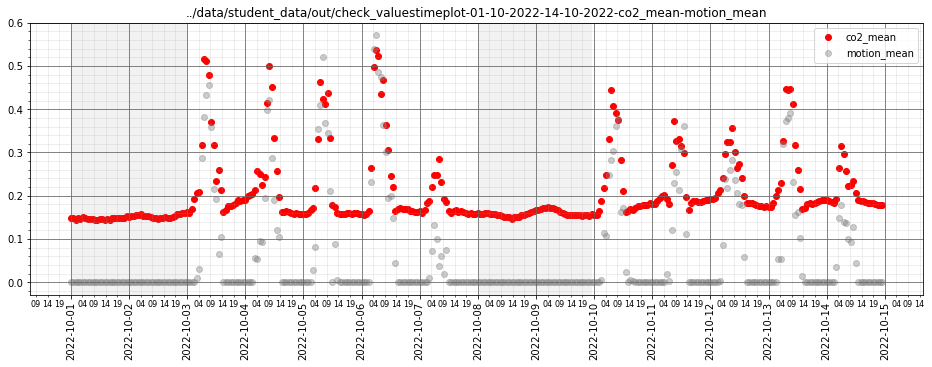

In [76]:
timeplotter.plot(folder+"out/check_values",second_floor_df,'co2_mean',columnname2='motion_mean')

TODO FIND REASON / CHECK TIME DIFFERENCE IN THIS DATA SEEMS SHIFT IN THE CLOCK?
- seasontime
- utc
- local database time?

In [ ]:
timeplotter.plot(folder+"out/check_values",second_floor_df,'co2_mean',columnname2='motion_mean')

In [59]:
### Define presence 2nd floor as binary >0.5
second_floor_df['presence']=second_floor_df['motion_mean']>0.05
print("spread of this target variable:")
print(second_floor_df['presence'].value_counts())

spread of this target variable:
False    250
True      86
Name: presence, dtype: int64


In [60]:
X_data.reset_index()
Y_data=second_floor_df[['datetime','presence']]

all_data=pd.merge(X_data,Y_data, how='inner', left_on="datetime", right_on="datetime")
all_data

,datetime,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,presence
0,2022-10-01 00:00:00,0.300613,0.0,0.417178,0.0,0.595092,0.0,0.269939,0.0,False
1,2022-10-01 01:00:00,0.294479,0.0,0.423313,0.0,0.582822,0.0,0.269939,0.0,False
2,2022-10-01 02:00:00,0.294479,0.0,0.429448,0.0,0.595092,0.0,0.269939,0.0,False
3,2022-10-01 03:00:00,0.288344,0.0,0.423313,0.0,0.582822,0.0,0.269939,0.0,False
4,2022-10-01 04:00:00,0.300613,0.0,0.423313,0.0,0.582822,0.0,0.269939,0.0,False
...,...,...,...,...,...,...,...,...,...,...
331,2022-10-14 19:00:00,0.343558,0.0,0.490798,0.0,0.730061,0.0,0.269939,0.0,False
332,2022-10-14 20:00:00,0.325153,0.0,0.484663,0.0,0.705521,0.0,0.269939,0.0,False
333,2022-10-14 21:00:00,0.343558,0.0,0.496933,0.0,0.730061,0.0,0.269939,0.0,False
334,2022-10-14 22:00:00,0.325153,0.0,0.478528,0.0,0.693252,0.0,0.269939,0.0,False


<h2>Save intermediate data</h2>

In [61]:
all_data.to_csv(folder+"out/occupation-data.csv",sep=";",index=False)

<h1>Load data</h1>
(convencience)

In [62]:
df=pd.read_csv(folder+"out/occupation-data.csv",sep=";")

df['datetime']=pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M')
df['month']=df['datetime'].dt.month
df['day']=df['datetime'].dt.day
df['week']=df['datetime'].dt.week

df.sample(5)

C:\Users\mulderw\AppData\Local\Temp\ipykernel_16184\4161538090.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week']=df['datetime'].dt.week


,datetime,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,presence,month,day,week
109,2022-10-05 13:00:00,0.674847,0.140351,0.723926,0.070175,0.840491,0.140351,0.625767,0.140351,True,10,5,40
156,2022-10-07 12:00:00,0.766871,0.263158,0.680982,0.035088,0.828221,0.192982,0.570552,0.245614,False,10,7,40
231,2022-10-10 15:00:00,0.515337,0.105263,0.453988,0.070175,0.668712,0.070175,0.282209,0.052632,False,10,10,41
308,2022-10-13 20:00:00,0.325153,0.000000,0.460123,0.000000,0.723926,0.000000,0.269939,0.000000,False,10,13,41
302,2022-10-13 14:00:00,0.515337,0.052632,0.533742,0.157895,0.760736,0.140351,0.368098,0.192982,False,10,13,41


<h2>Create model</h2>
<p>
    <b>Training Dataset</b>: The sample of dataset that is used to fit the statistical data model.
</p>
<p><b>Validation set</b> is often used interchangeably with the term <b>test set</b> and refers to a sample of the dataset <i>held back</i> from training the model. The model is evaluated on this held-out sample to give an unbiased results. This is typically called a train-test split approach to algorithm evaluation. It is used to while tuning model hyperparameters when learning the model. <p>
    <b>Test Dataset</b>: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.    
    </p>
<p> source:https://machinelearningmastery.com/difference-test-validation-datasets/
    </p>

In [63]:
print("Weeks : ",df['week'].unique())
weeks=[39,40]
mask=(df['week'].isin(weeks))
df_model=df[mask].copy()
df_model.sample(5)

Weeks :  [39 40 41]


,datetime,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,presence,month,day,week
18,2022-10-01 18:00:00,0.300613,0.000000,0.453988,0.000000,0.625767,0.000000,0.269939,0.000000,False,10,1,39
105,2022-10-05 09:00:00,0.963190,0.456140,0.846626,0.631579,0.938650,0.736842,0.852761,0.649123,True,10,5,40
62,2022-10-03 14:00:00,0.546012,0.105263,0.613497,0.263158,0.791411,0.280702,0.619632,0.263158,True,10,3,40
68,2022-10-03 20:00:00,0.496933,0.000000,0.429448,0.000000,0.595092,0.000000,0.269939,0.000000,False,10,3,40
90,2022-10-04 18:00:00,0.300613,0.000000,0.417178,0.000000,0.595092,0.000000,0.269939,0.000000,False,10,4,40


In [64]:
#Determine the columns of X
#Make sure X is of the right shape and properly cleaned. Think of the following:
#The output variable Y should not occur as column in the input dataframe X, likewise for any column directly related to the output variable. 
#Which columns can be dropped without loss of information, or which could cause overfitting? 
X = df_model.copy()

#drop the variable(s) that is(are) used to calculate the target variable
X= X.drop(['datetime'],axis=1)
        
#drop the target_variable
X= X.drop(['presence'],axis=1)

#target column
y = df_model['presence']  

#Split the dataset in a training set and a test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, test_size=0.4, shuffle = True, random_state=42)

#Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
#Predict the test values using the model
predicted_values = clf.predict(X_test)

In [65]:
X.sample(5)

,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,month,day,week
159,0.319018,0.000000,0.423313,0.0,0.619632,0.0,0.269939,0.000000,10,7,40
88,0.496933,0.000000,0.429448,0.0,0.607362,0.0,0.269939,0.000000,10,4,40
115,0.312883,0.000000,0.496933,0.0,0.680982,0.0,0.269939,0.000000,10,5,40
195,0.300613,0.000000,0.380368,0.0,0.582822,0.0,0.269939,0.000000,10,9,40
75,0.503067,0.035088,0.460123,0.0,0.619632,0.0,0.269939,0.035088,10,4,40


In [66]:
y.value_counts()

False    173
True      43
Name: presence, dtype: int64

<h2>Model evaluation</h2>

In [67]:
#Calc the confusion matrix
#Compare y_test and the predicted values in step d. using a confusion matrix.
cm=confusion_matrix(y_test, predicted_values)
cm_df = pd.DataFrame(cm,columns=["Predicted 0", "Predicted 1"], 
                  index=["Actual 0", "Actual 1"])
cm_df = pd.DataFrame(cm,columns=["Predicted 0", "Predicted 1"], 
                  index=["Actual 0", "Actual 1"])
print(cm_df)

# Compute the following metrics: 
# - Mean avarage error
# - Root mean square error
# - accuracy score
# - Precision
# - Recall
# - F1-score
results={'datasize':str(X.shape),
 #'mae': metrics.mean_absolute_error(y_test, predicted_values),
 #'rmse': metrics.mean_squared_error(y_test, predicted_values),
 'accuracy_score': metrics.accuracy_score(y_test, predicted_values)}        
recall = metrics.recall_score(y_test, predicted_values)
precision = metrics.precision_score(y_test, predicted_values)
f1_score = metrics.f1_score(y_test, predicted_values)
print(results)
print('recall:', recall)
print('precision:', precision)
print('f1 score:', f1_score)

          Predicted 0  Predicted 1
Actual 0           68            2
Actual 1            2           15
{'datasize': '(216, 11)', 'accuracy_score': 0.9540229885057471}
recall: 0.8823529411764706
precision: 0.8823529411764706
f1 score: 0.8823529411764706


<h2>Feature importances</h2>

In [68]:
#Show feature importances
#Sort the feature importances descending, and inspect what the most relevant features are. 
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X.columns[i] for i in indices]
print("features  (sorted on importance) : ", names)


features  (sorted on importance) :  ['soundAvg_Julian', 'soundAvg_Karel', 'motion_Karel', 'soundAvg_Yvonne', 'motion_Julian', 'motion_Laura', 'motion_Yvonne', 'soundAvg_Laura', 'day', 'week', 'month']


<h1>ROC curve Training / Test data Graphs</h1>

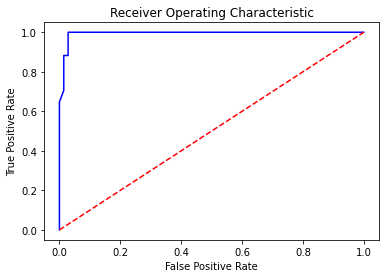

In [69]:
fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("roc.pdf")
plt.show()

<h1>Select Test data to really test </h1>

In [70]:
weeks=[41]
mask=(df['week'].isin(weeks))
df_test=df[mask].copy()
df_test.sample(5)

,datetime,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,presence,month,day,week
245,2022-10-11 05:00:00,0.803681,0.912281,0.680982,0.017544,0.840491,0.491228,0.680982,0.666667,False,10,11,41
320,2022-10-14 08:00:00,0.674847,0.280702,0.748466,0.421053,0.957055,0.649123,0.660123,0.610526,True,10,14,41
250,2022-10-11 10:00:00,0.828221,0.350877,0.809816,0.701754,0.914110,0.719298,0.779141,0.789474,True,10,11,41
309,2022-10-13 21:00:00,0.337423,0.000000,0.429448,0.000000,0.723926,0.000000,0.269939,0.000000,False,10,13,41
253,2022-10-11 13:00:00,0.631902,0.192982,0.742331,0.245614,0.877301,0.315789,0.662577,0.473684,True,10,11,41


In [71]:
X_test=df_test.copy()
#drop the variable(s) that is(are) used to calculate the target variable
X_test= X_test.drop(['datetime'],axis=1)
#drop the target_variable
X_test= X_test.drop(['presence'],axis=1)

#Predict goal using the model
predicted_values = clf.predict(X_test)

df_test['presence_predicted']=predicted_values
proba = clf.predict_proba(X_test) #returns an array of [p0,p1] pairs
proba=list(map(max, proba)) #now a column with the max of each p0 p1 pair
df_test['probability']=proba
df_test.sample(5)


,datetime,soundAvg_Karel,motion_Karel,soundAvg_Julian,motion_Julian,soundAvg_Yvonne,motion_Yvonne,soundAvg_Laura,motion_Laura,presence,month,day,week,presence_predicted,probability
269,2022-10-12 05:00:00,0.699387,0.596491,0.631902,0.228070,0.803681,0.438596,0.503067,0.543860,True,10,12,41,True,0.87
295,2022-10-13 07:00:00,0.613497,0.263158,0.619632,0.421053,0.803681,0.315789,0.656442,0.631579,True,10,13,41,True,0.73
312,2022-10-14 00:00:00,0.325153,0.000000,0.447853,0.000000,0.723926,0.000000,0.269939,0.000000,False,10,14,41,False,1.00
291,2022-10-13 03:00:00,0.496933,0.052632,0.441718,0.000000,0.705521,0.017544,0.276074,0.052632,False,10,13,41,False,1.00
221,2022-10-10 05:00:00,0.570552,0.385965,0.588957,0.228070,0.779141,0.350877,0.484663,0.245614,True,10,10,41,False,0.63


In [72]:
#Calc the confusion matrix
#Compare y_test and the predicted values in step d. using a confusion matrix.
y_test=df_test['presence']
cm=confusion_matrix(y_test, predicted_values)
cm_df = pd.DataFrame(cm,columns=["Predicted 0", "Predicted 1"], 
                  index=["Actual 0", "Actual 1"])
cm_df = pd.DataFrame(cm,columns=["Predicted 0", "Predicted 1"], 
                  index=["Actual 0", "Actual 1"])
print(cm_df)

# Compute the following metrics: 
# - Mean avarage error
# - Root mean square error
# - accuracy score
# - Precision
# - Recall
# - F1-score
results={'datasize':str(X.shape),
 #'mae': metrics.mean_absolute_error(y_test, predicted_values),
 #'rmse': metrics.mean_squared_error(y_test, predicted_values),
 'accuracy_score': metrics.accuracy_score(y_test, predicted_values)}        
recall = metrics.recall_score(y_test, predicted_values)
precision = metrics.precision_score(y_test, predicted_values)
f1_score = metrics.f1_score(y_test, predicted_values)
print(results)
print('recall:', recall)
print('precision:', precision)
print('f1 score:', f1_score)

          Predicted 0  Predicted 1
Actual 0           73            4
Actual 1            5           38
{'datasize': '(216, 11)', 'accuracy_score': 0.925}
recall: 0.8837209302325582
precision: 0.9047619047619048
f1 score: 0.8941176470588236


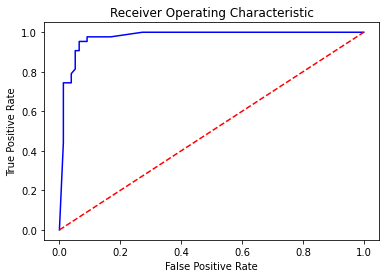

In [73]:
fpr, tpr, threshold = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.plot([0, 1], [0, 1],'r--')
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.savefig("roc.pdf")
plt.show()

### Final graph to show the results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


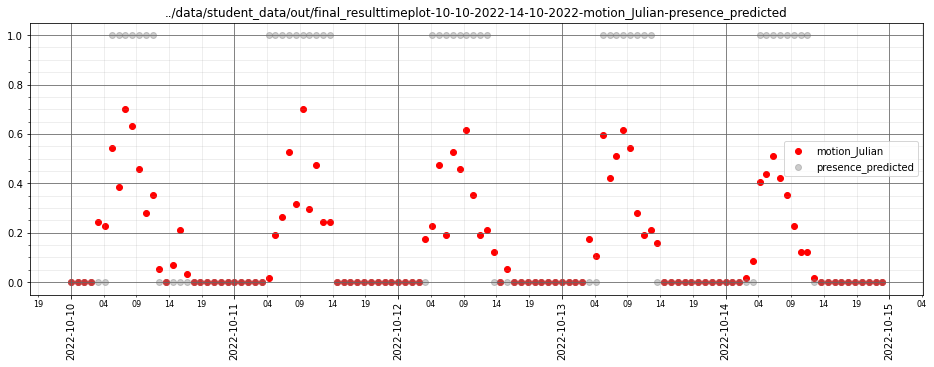

In [74]:
%load_ext autoreload
%autoreload 2

from TimePlotter import TimePlotter
df=df_test.copy()

df['presence_predicted']=df['presence_predicted'].astype(int)
timeplotter=TimePlotter()
timeplotter.plot(folder+"out/final_result",df,'motion_Julian',columnname2='presence_predicted')

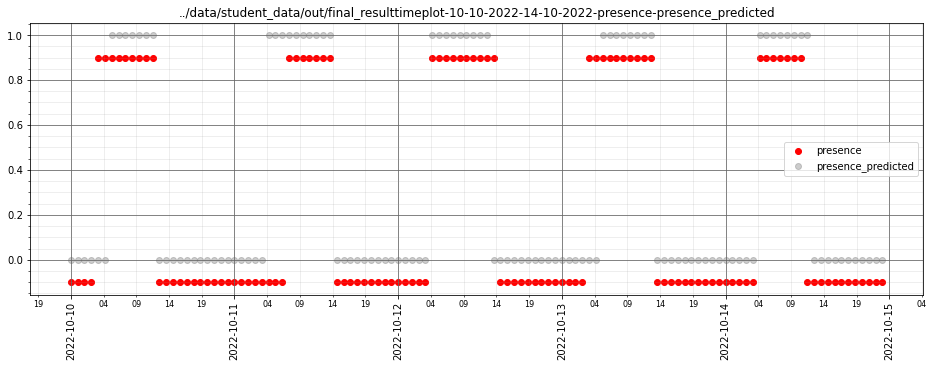

In [75]:
df['presence']=df['presence'].astype(int)-0.1
timeplotter.plot(folder+"out/final_result",df,'presence',columnname2='presence_predicted')